In [7]:
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode

import sys
from pathlib import Path

notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.append(str(project_root))

from utils import DiffusionModelPipeline, ImagePromptDataset

## Initialize Model

In [8]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'inC': 16, 
    'nHeads': 8,
    'patchSize': 2
}

cat_params = {
    'input_dim': 768,  # T5-base hidden size
    'hidden_dim': 512,
    'output_dim': 256,
    'num_layers': 3,
    'num_heads': 8
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
untrained_model = model = DiffusionModelPipeline(dit_params = dit_params,
                       cat_params = cat_params,
                       emaStrength= 0.999,
                       )

# loaded_model = DiffusionModelPipeline.from_pretrained('pokemon_training_test/epoch_1000')


## Single Model Generation Test

In [ ]:
prompts = ['A green pokemon with a leaf on its head',
                      'a red pokemon with a fire on its tail',
                      'a yellow cartoon character with a big smile',
                      'a cartoon frog character with a crown',]

img = untrained_model.generate(prompts,
               num_inference_steps=50)


# img = loaded_model.generate(prompts,
#                num_inference_steps=50)

fig, ax = plt.subplots(1, len(prompts), figsize=(20, 5))
for i, imgs in enumerate(img):
       ax[i].imshow(imgs)
       ax[i].axis('off')
       ax[i].set_title(prompts[i])
plt.show()

## Multi-Model Generation Test
for Comparisions

In [ ]:
##Load models for comparision, based off of code example below:

trained_1k_model = DiffusionModelPipeline.from_pretrained('pokemon_training_test/epoch_1000')

trained_best_model = DiffusionModelPipeline.from_pretrained('pokemon_training_test/best_model')

In [9]:
prompts = ['A green pokemon with a leaf on its head',
                      'a red pokemon with a fire on its tail',
                      'a yellow cartoon character with a big smile',
                      'a cartoon frog character with a crown',]

steps = 10
shape = (len(prompts), untrained_model.latent_channels, 16, 16)
xT = torch.rand(shape).to(device)

Diffusion: 100%|██████████| 10/10 [00:00<00:00, 82.35it/s]


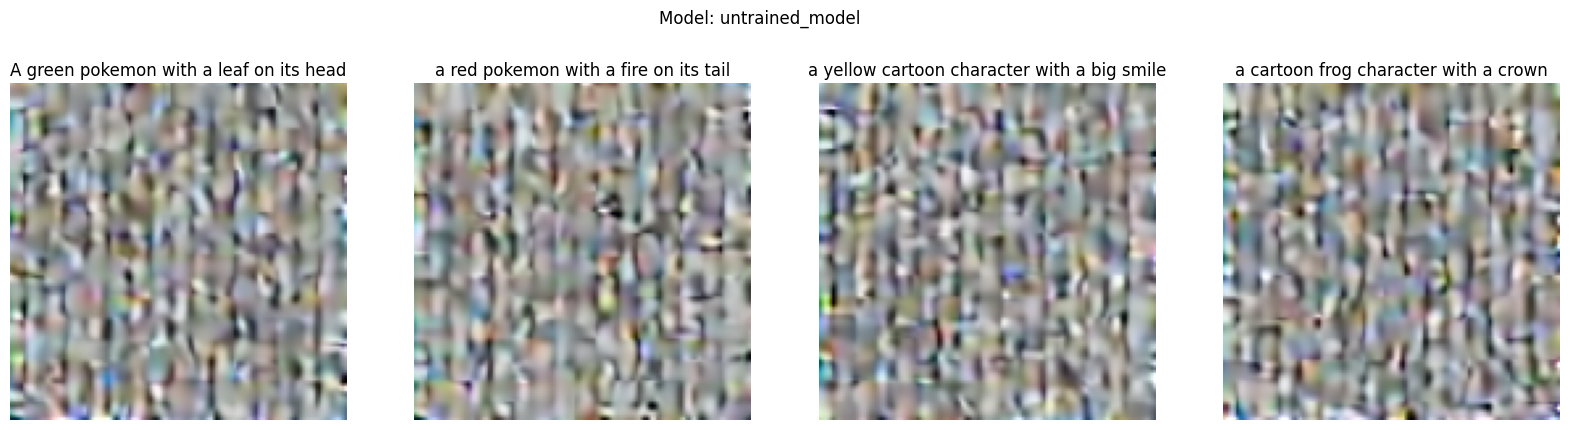

Diffusion: 100%|██████████| 10/10 [00:00<00:00, 67.57it/s]


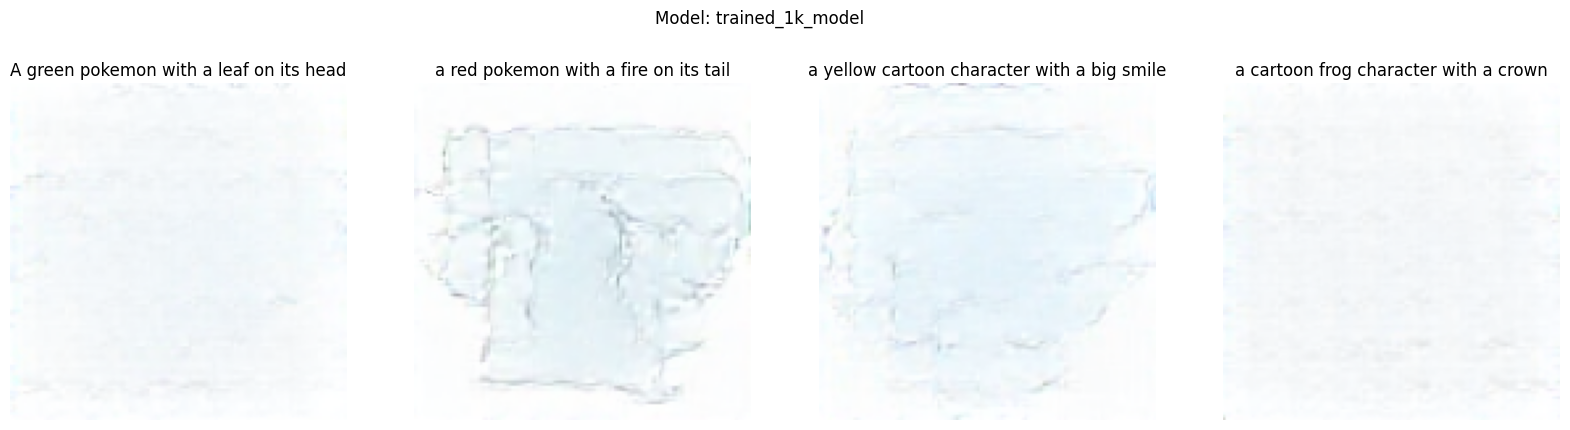

Diffusion: 100%|██████████| 10/10 [00:00<00:00, 74.23it/s]


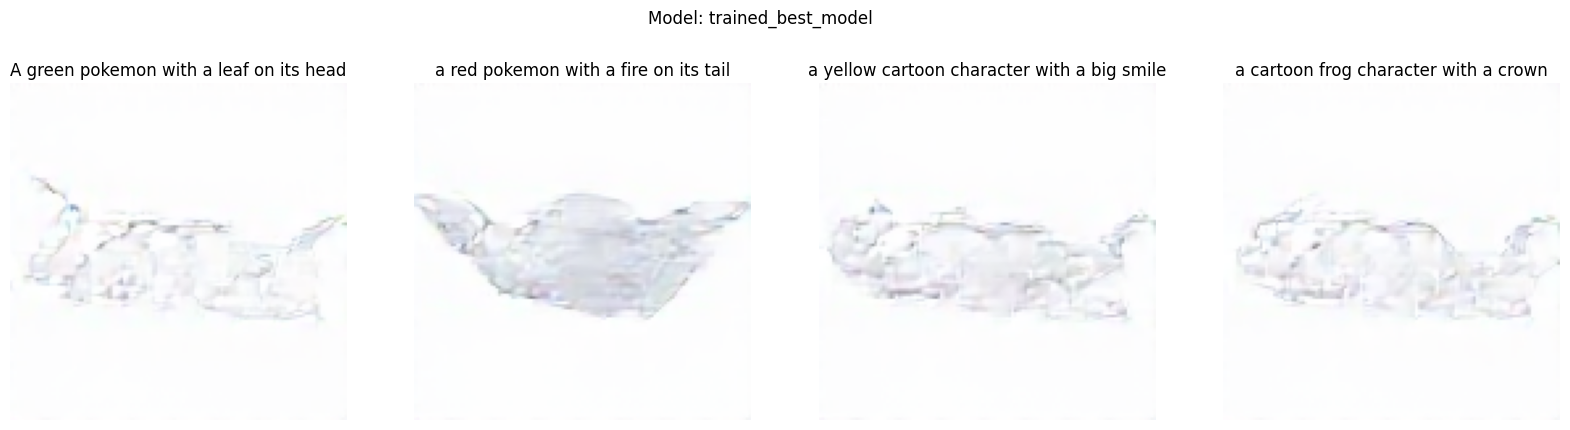

In [10]:
mods = ['untrained_model', 'trained_1k_model', "trained_best_model"]
for ii, mod in enumerate([untrained_model, trained_1k_model, trained_best_model]):
    mod.to(device)
    mod.vae.eval()
    mod.text_encoder.eval()
    mod.cat.eval()
    mod.diffusion_model.model.eval()
    
    with torch.no_grad():
        
        text_embeddings = mod.encode_text(prompts)    
        
        ##Next we call the diffusion model -> hgere we do have XT random
        with torch.no_grad():
            for i in tqdm(range(0, steps), desc="Diffusion"):
                if i == 0:
                    latents = xT
                    
                latents = mod.diffusion_model.vSample(i, shape, latents, steps, text_embeddings)
        images = mod.decode_latents(latents)
        
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = [Image.fromarray((image * 255).astype(np.uint8)) for image in images]
    
    fig, ax = plt.subplots(1, len(prompts), figsize=(20, 5))
    fig.suptitle(f"Model: {mods[ii]}")
    for i, img in enumerate(images):
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(prompts[i])
    plt.show()
    